# Example 1
Here we calculating spectral functions and ground state energy using quantum enhanced spectral moments and RDMs. 

In [1]:
# PySCF, Vayesta and Dyson imports 
from pyscf import fci, gto
from vayesta.lattmod import Hubbard1D, LatticeRHF
from dyson import MBLGF, MixedMBLGF, FCI, Lehmann, util, NullLogger
from dyson.util import greens_function_galitskii_migdal

# General and Qesm imports
import numpy as np
from qesm.aer_recursive import *
from qesm.aer_direct import *
from qesm.aer_rdm import *
from qesm.aer_util import primatives
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# hubbard dimer
grid = np.linspace(-20,20,10000) 
nmom = 1 # number of moments to compute
u_hub = 7
nsite = 2
mol_hub = Hubbard1D(

    nsite=nsite,
    nelectron=nsite, # half filling
    hubbard_u=u_hub,
    verbose=0,
)

mf_hub = LatticeRHF(mol_hub)
mf_hub.kernel()
myci = fci.FCI(mf_hub, mf_hub.mo_coeff)

#fci observables
fci_energy , fci_vecs = myci.kernel()
fci_1rdm = myci.make_rdm1(fci_vecs, mf_hub.mo_coeff.shape[1],mol_hub.nelec)
fci_2rdm = myci.make_rdm2(fci_vecs, mf_hub.mo_coeff.shape[1],mol_hub.nelec)

###################### FCI spectral function ###################### 

expr = FCI["1h"](mf_hub, mo_energy=mf_hub.mo_energy, mo_coeff=mf_hub.mo_coeff, mo_occ=mf_hub.mo_occ)
th_fci = expr.build_gf_moments(nmom+1)

expr = FCI["1p"](mf_hub, mo_energy=mf_hub.mo_energy, mo_coeff=mf_hub.mo_coeff, mo_occ=mf_hub.mo_occ)
tp_fci = expr.build_gf_moments(nmom+1)

solverh = MBLGF(th_fci, log=NullLogger())
solverp = MBLGF(tp_fci, log=NullLogger())
solver = MixedMBLGF(solverh, solverp)
solver.kernel()
E,V = solver.get_dyson_orbitals()
sf_fci = util.build_spectral_function(E, V, grid, eta=0.01)
#########################################################

In [3]:
# set up primatives 
prims = primatives(shots=100000)
sv_estimator = prims['sv estimator']
estimator = prims['estimator']
simulator = prims['simulator']

# initialise methods 
rec_obj = RecursiveMethod(
    mf=mf_hub,
    vqe_estimator=sv_estimator,
    simulator=simulator,
)
dir_obj = DirectMethod(
    mf=mf_hub,
    vqe_estimator=sv_estimator,
    expectation_estimator=estimator,
)
rdm_obj = RDMs(
    mf=mf_hub,
    vqe_estimator=sv_estimator,
    expectation_estimator=estimator,
)

In [4]:
# Calculating ground state energy via recursive, direct and RDM methods. 

rdm_energy = rdm_obj.get_energy()
rec_energy = rec_obj.get_galitski_migdal_energy(maxiter=100, optimizer='slsqp')
dir_energy = dir_obj.get_galitski_migdal_energy(maxiter=100, optimizer='slsqp')

# check that the energies are equal to the FCI energy
print(f"FCI energy: {fci_energy}")
print(f"Recursive energy: {rec_energy}")
print(f"Direct energy: {dir_energy}")
print(f"RDM energy: {rdm_energy}")


FCI energy: -0.531128874149271
Recursive energy: -0.5404455647558335
Direct energy: -0.5261499007329872
RDM energy: -0.5552050268239037


In [5]:
# Calculating the spectral function via recursive and direct methods, then comparing to the FCI spectral function.
rec_sf = rec_obj.get_spectral_function(grid, nmom=nmom, maxiter=100, optimizer='slsqp')
dir_sf = dir_obj.get_spectral_function(grid, nmom=nmom, maxiter=100, optimizer='slsqp')

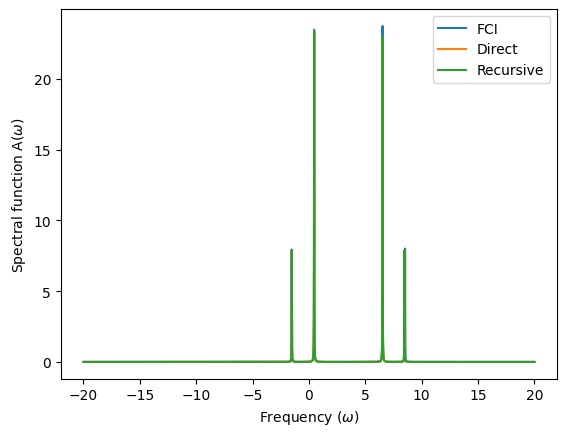

In [7]:
# plt.axvline(x=0.0,color='black')
plt.plot(grid,sf_fci,'-',label='FCI')
plt.plot(grid,dir_sf['spectral function'], '-',label='Direct')
plt.plot(grid,dir_sf['spectral function'], '-',label='Recursive')
plt.xlabel("Frequency ($\omega$)")
plt.ylabel("Spectral function A($\omega$)")
plt.legend()
plt.show()